## Data Processing and Modeling

In [37]:
import pandas as pd
import numpy as np

### Section 1: Data Processing

In [38]:
df = pd.read_csv("../Data/earthquake_usgs_raw.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1421 non-null   object 
 1   magnitude  1421 non-null   float64
 2   cdi        751 non-null    float64
 3   mmi        1126 non-null   float64
 4   sig        1421 non-null   int64  
 5   nst        780 non-null    float64
 6   dmin       528 non-null    float64
 7   gap        1039 non-null   float64
 8   depth      1421 non-null   float64
 9   latitude   1421 non-null   float64
 10  longitude  1421 non-null   float64
 11  year       1421 non-null   int64  
 12  month      1421 non-null   int64  
 13  tsunami    1421 non-null   int64  
 14  place      1420 non-null   object 
 15  alert      565 non-null    object 
 16  magType    1421 non-null   object 
 17  rms        1410 non-null   float64
 18  code       1421 non-null   object 
 19  net        1421 non-null   object 
 20  type    

In [39]:
for col in df.columns:
    n_unique = df[col].nunique()
    print(f"{col:20s}: {n_unique:6d} unique values")

title               :   1328 unique values
magnitude           :     26 unique values
cdi                 :     71 unique values
mmi                 :    979 unique values
sig                 :    384 unique values
nst                 :    467 unique values
dmin                :    507 unique values
gap                 :    316 unique values
depth               :    546 unique values
latitude            :   1418 unique values
longitude           :   1416 unique values
year                :     31 unique values
month               :     12 unique values
tsunami             :      2 unique values
place               :   1187 unique values
alert               :      4 unique values
magType             :      8 unique values
rms                 :    121 unique values
code                :   1421 unique values
net                 :      9 unique values
type                :      1 unique values
status              :      1 unique values
datetime            :   1421 unique values


#### 1. Drop unnecessary columns <br>
Drop columns that are not needed for the analysis. The columns are:
- `title`: Combination of 'magnitude' and 'place' information, provides no additional predictive value.

- `place`: Text description of location, duplicates geographic information already captured by 'latitude' and 'longitude' coordinates.

- `alert`: Alert level generated after the event occurs, causing data leakage. Highly correlated with 'magnitude'. Additionally, contains 60% missing values.

- `datetime`: Already split into 'Year' and 'Month' features, making the original column redundant.

- `code`: Event identifier code with no predictive value for tsunami occurrence.

- `status`: Review status indicator - metadata unrelated to earthquake physics or tsunami prediction.

- `net`: Data contributor network ID, not relevant for predictive modeling.

- `type`: Event type classification - all records are "earthquake", no variance.


In [40]:
drop_cols = ['title', 'place', 'alert', 'datetime', 'code', 'status', 'net', 'type']
df_cleaned = df.drop(columns=drop_cols)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1421 non-null   float64
 1   cdi        751 non-null    float64
 2   mmi        1126 non-null   float64
 3   sig        1421 non-null   int64  
 4   nst        780 non-null    float64
 5   dmin       528 non-null    float64
 6   gap        1039 non-null   float64
 7   depth      1421 non-null   float64
 8   latitude   1421 non-null   float64
 9   longitude  1421 non-null   float64
 10  year       1421 non-null   int64  
 11  month      1421 non-null   int64  
 12  tsunami    1421 non-null   int64  
 13  magType    1421 non-null   object 
 14  rms        1410 non-null   float64
dtypes: float64(10), int64(4), object(1)
memory usage: 166.7+ KB


#### 2. Handling missing values

a. `cdi` , `mmi` are intensity metrics filling with conditional median<br>
a. `cdi` , `mmi` are intensity metrics filling with median

In [41]:
from src.data_cleaning import *
df_base = df_cleaned.copy()
df_conditional = df_base.copy()
target_cols = ['cdi', 'mmi']
for col in target_cols:
    df_conditional = impute_with_conditional_median(df_conditional, col, 'magnitude', 0.5)
df_simple = df_base.copy()
df_simple = impute_with_median(df_simple, target_cols)

print(df_conditional.info())
print(df_simple.info())
print(df_conditional.describe())
print(df_simple.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1421 non-null   float64
 1   cdi        1421 non-null   float64
 2   mmi        1421 non-null   float64
 3   sig        1421 non-null   int64  
 4   nst        780 non-null    float64
 5   dmin       528 non-null    float64
 6   gap        1039 non-null   float64
 7   depth      1421 non-null   float64
 8   latitude   1421 non-null   float64
 9   longitude  1421 non-null   float64
 10  year       1421 non-null   int64  
 11  month      1421 non-null   int64  
 12  tsunami    1421 non-null   int64  
 13  magType    1421 non-null   object 
 14  rms        1410 non-null   float64
dtypes: float64(10), int64(4), object(1)
memory usage: 166.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtyp

b. `nst` `dmin` `gap` `rms` used to evaluate data quality, filling with median

In [42]:
quality_cols = ['nst', 'dmin', 'gap', 'rms']
df_conditional = impute_with_median(df_conditional, quality_cols)
df_simple = impute_with_median(df_simple, quality_cols)
print(df_conditional.info())
print(df_simple.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1421 non-null   float64
 1   cdi        1421 non-null   float64
 2   mmi        1421 non-null   float64
 3   sig        1421 non-null   int64  
 4   nst        1421 non-null   float64
 5   dmin       1421 non-null   float64
 6   gap        1421 non-null   float64
 7   depth      1421 non-null   float64
 8   latitude   1421 non-null   float64
 9   longitude  1421 non-null   float64
 10  year       1421 non-null   int64  
 11  month      1421 non-null   int64  
 12  tsunami    1421 non-null   int64  
 13  magType    1421 non-null   object 
 14  rms        1421 non-null   float64
dtypes: float64(10), int64(4), object(1)
memory usage: 166.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtyp

#### 3. Feature Engineering
a. latitude and longitude are converted to 3D cartesian coordinates

In [43]:
from src.feature_engineering import *
df_processed_1 = df_conditional.copy()
df_processed_1 = convert_to_cartesian(df_processed_1)
print(df_processed_1[['latitude', 'longitude', 'X', 'Y', 'Z']].head())

df_processed_2 = df_simple.copy()
df_processed_2 = convert_to_cartesian(df_processed_2)

   latitude  longitude         X         Y         Z
0   16.5416   -59.5832  0.485333 -0.826675  0.284711
1   -2.1588   138.9374 -0.753457  0.656417 -0.037669
2  -60.1885   -61.8238  0.234746 -0.438236 -0.867666
3    7.2127   126.6578 -0.592310  0.795868  0.125553
4    7.2866   126.6902 -0.592663  0.795402  0.126833


b. `depth`, `dmin`, `gap`, `sig`, are right skewed, using log transformation

In [44]:
cols_to_log_transform = ['depth', 'dmin', 'gap', 'sig']

df_logged_1 = apply_log1p_transformation(
    df=df_processed_1,
    target_cols=cols_to_log_transform,
    drop_original=False
)

df_logged_2 = apply_log1p_transformation(
    df=df_processed_2,
    target_cols=cols_to_log_transform,
    drop_original=False
)

print(df_logged_1.describe())


         magnitude          cdi          mmi          sig          nst  \
count  1421.000000  1421.000000  1421.000000  1421.000000  1421.000000   
mean      6.893709     5.738388     5.869844   821.474314   398.641802   
std       0.409723     1.602756     1.602396   295.710922   136.416122   
min       6.500000     0.000000     0.000000   650.000000    10.000000   
25%       6.600000     5.300000     5.372000   670.000000   382.000000   
50%       6.800000     5.400000     6.067000   732.000000   402.000000   
75%       7.100000     6.800000     6.744000   833.000000   420.000000   
max       9.100000     9.100000    10.000000  2910.000000   934.000000   

              dmin          gap        depth     latitude    longitude  ...  \
count  1421.000000  1421.000000  1421.000000  1421.000000  1421.000000  ...   
mean      2.656403    26.306819    90.870759     2.066565    47.447419  ...   
std       2.225761    19.755519   159.127915    29.392555   121.716809  ...   
min       0.04616

c. Encoding categorical variables `magType`

In [45]:
print(df['magType'].value_counts())
df_encoder_1 = df_logged_1.copy()

df_encoder_1_onehot = apply_one_hot_encoding(
    df=df_encoder_1,
    target_cols=['magType'],
    drop_first=True
)
print(df_encoder_1_onehot.head())


magType
mww    642
mwc    517
mwb    164
mw      83
mb       8
ms       4
md       2
ml       1
Name: count, dtype: int64
   magnitude  cdi    mmi   sig    nst   dmin   gap   depth  latitude  \
0        6.5  4.3  3.876   702  161.0  1.432  21.0   9.000   16.5416   
1        6.5  3.1  6.732   651  109.0  0.911  25.0  33.301   -2.1588   
2        7.6  9.0  3.941   893  402.0  4.717  12.0   6.505  -60.1885   
3        6.7  6.4  6.282   725  129.0  1.080  25.0  47.000    7.2127   
4        7.4  6.7  7.284  1024  291.0  1.123  19.0  59.425    7.2866   

   longitude  ...  dmin_log   gap_log   sig_log  magType_md  magType_ml  \
0   -59.5832  ...  0.888714  3.091042  6.555357           0           0   
1   138.9374  ...  0.647627  3.258097  6.480045           0           0   
2   -61.8238  ...  1.743444  2.564949  6.795706           0           0   
3   126.6578  ...  0.732368  3.258097  6.587550           0           0   
4   126.6902  ...  0.752830  2.995732  6.932448           0           

### Section 2: Training and Modeling

#### 1. Train-test split

In [46]:
X_onehot = df_encoder_1_onehot.drop(columns=['tsunami', 'latitude', 'longitude', 'depth', 'sig', 'gap', 'dmin'])
y = df_encoder_1_onehot['tsunami']

print(X_onehot.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   magnitude    1421 non-null   float64
 1   cdi          1421 non-null   float64
 2   mmi          1421 non-null   float64
 3   nst          1421 non-null   float64
 4   year         1421 non-null   int64  
 5   month        1421 non-null   int64  
 6   rms          1421 non-null   float64
 7   X            1421 non-null   float64
 8   Y            1421 non-null   float64
 9   Z            1421 non-null   float64
 10  depth_log    1421 non-null   float64
 11  dmin_log     1421 non-null   float64
 12  gap_log      1421 non-null   float64
 13  sig_log      1421 non-null   float64
 14  magType_md   1421 non-null   int64  
 15  magType_ml   1421 non-null   int64  
 16  magType_ms   1421 non-null   int64  
 17  magType_mw   1421 non-null   int64  
 18  magType_mwb  1421 non-null   int64  
 19  magTyp

In [47]:
from sklearn.model_selection import train_test_split

# One-hot
X_train_onehot, X_test_onehot, y_train_onehot, y_test_onehot = train_test_split(
    X_onehot, y, test_size=0.2, random_state=42
)

print(y_train_onehot.value_counts(normalize=True))
print(y_test_onehot.value_counts(normalize=True))

tsunami
0    0.716549
1    0.283451
Name: proportion, dtype: float64
tsunami
0    0.712281
1    0.287719
Name: proportion, dtype: float64


#### 2. Feature scaling

In [48]:
from src.model_training import *
exclude_cols_onehot = [col for col in X_train_onehot.columns if 'magType_' in col]

X_train_onehot_scaled, X_test_onehot_scaled = scale_train_test(
    X_train_onehot, X_test_onehot, exclude_cols=exclude_cols_onehot
)


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf_onehot = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_onehot.fit(X_train_onehot_scaled, y_train_onehot)
y_pred_rf_onehot = rf_onehot.predict(X_test_onehot_scaled)

print("Random Forest (One-hot) Accuracy:", accuracy_score(y_test_onehot, y_pred_rf_onehot))
print(classification_report(y_test_onehot, y_pred_rf_onehot))
print("Confusion Matrix:\n", confusion_matrix(y_test_onehot, y_pred_rf_onehot))


Random Forest (One-hot) Accuracy: 0.9438596491228071
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       203
           1       0.85      0.98      0.91        82

    accuracy                           0.94       285
   macro avg       0.92      0.95      0.93       285
weighted avg       0.95      0.94      0.94       285

Confusion Matrix:
 [[189  14]
 [  2  80]]



Top 10 Most Important Features:
    feature  importance
       year    0.347562
magType_mww    0.149192
magType_mwc    0.077443
          Y    0.071855
   dmin_log    0.063147
        nst    0.047042
          X    0.037435
        rms    0.034303
          Z    0.025849
  depth_log    0.025830


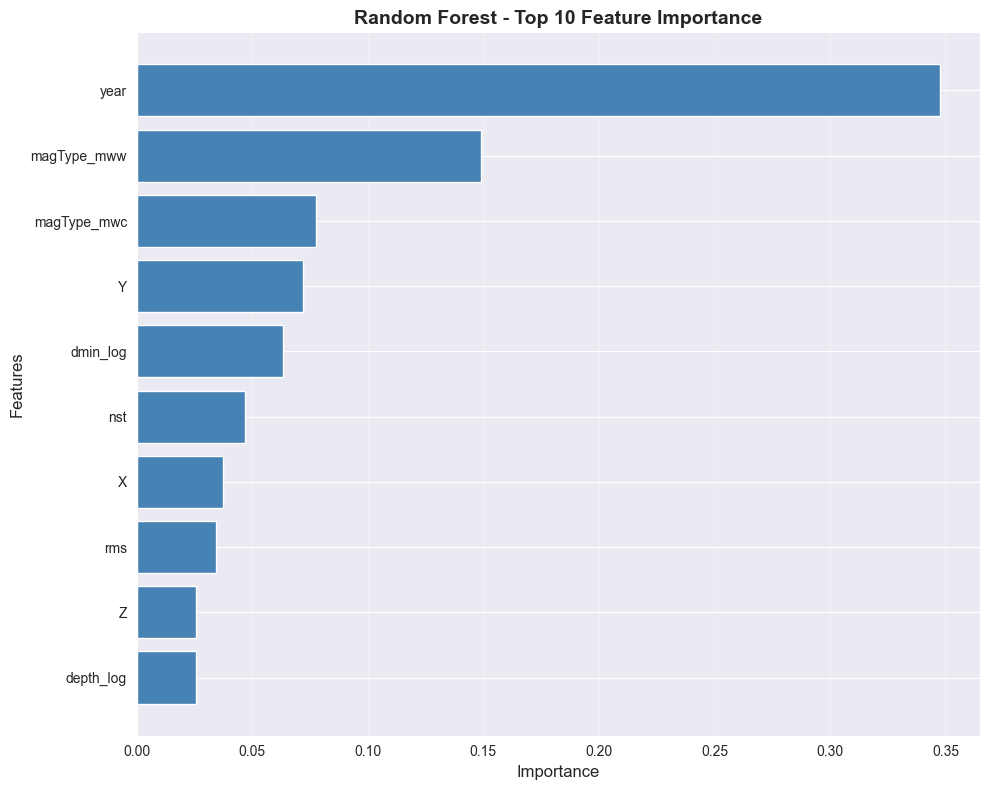

In [50]:
feature_importance = rf_onehot.feature_importances_

importance_df = pd.DataFrame({
    'feature': X_train_onehot_scaled.columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Top 10
print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
top_n = 10
top_features = importance_df.head(top_n)

plt.barh(top_features['feature'], top_features['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Random Forest - Top {top_n} Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


In [51]:
knn_onehot = KNeighborsClassifier(n_neighbors=5)
knn_onehot.fit(X_train_onehot_scaled, y_train_onehot)
y_pred_knn_onehot = knn_onehot.predict(X_test_onehot_scaled)

print("KNN (One-hot) Accuracy:", accuracy_score(y_test_onehot, y_pred_knn_onehot))
print(classification_report(y_test_onehot, y_pred_knn_onehot))
print("Confusion Matrix:\n", confusion_matrix(y_test_onehot, y_pred_knn_onehot))


KNN (One-hot) Accuracy: 0.8947368421052632
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       203
           1       0.77      0.90      0.83        82

    accuracy                           0.89       285
   macro avg       0.86      0.90      0.88       285
weighted avg       0.90      0.89      0.90       285

Confusion Matrix:
 [[181  22]
 [  8  74]]


In [52]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(max_iter=2000)
log_clf.fit(X_train_onehot_scaled, y_train_onehot)

log_pred = log_clf.predict(X_test_onehot_scaled)

from sklearn.metrics import accuracy_score

print("Logistic Regression Accuracy:", accuracy_score(y_test_onehot, log_pred))
print("Logistic Regression Classification Report:")
print(classification_report(y_test_onehot, log_pred))

Logistic Regression Accuracy: 0.887719298245614
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       203
           1       0.77      0.87      0.82        82

    accuracy                           0.89       285
   macro avg       0.86      0.88      0.87       285
weighted avg       0.89      0.89      0.89       285



In [53]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

xgb_clf.fit(X_train_onehot_scaled, y_train_onehot)
xgb_pred = xgb_clf.predict(X_test_onehot_scaled)

In [54]:

print("XGBoost Accuracy:", accuracy_score(y_test_onehot, xgb_pred))
print(classification_report(y_test_onehot, xgb_pred))

XGBoost Accuracy: 0.9508771929824561
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       203
           1       0.89      0.95      0.92        82

    accuracy                           0.95       285
   macro avg       0.93      0.95      0.94       285
weighted avg       0.95      0.95      0.95       285

